In [1]:
%load_ext autoreload
%autoreload 2

### Conceptlab Concept Annotation Example

In [2]:
import sys
SRC_DIR = '../'
if SRC_DIR not in sys.path:
    sys.path.append(SRC_DIR)

In [3]:
import conceptlab as clab
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import anndata as ad
import scanpy as sc

To perform set-based concept annotation of the omics data, we will need a matrix `M` with the dimensions `[n_features] x [n_sets]`, where `M_ij = 1` indicates that feature i is a part of set j; similarly `M_ij = 0` indicates that feature i is not a part of j.

This type of matrix can be created in any way you liked, or even stored; here we'll read information from a pathway database and create it ourselves.

In this example we'll use the Gene Ontology (GO) Pathway database, this can be downloaded as a `.gaf` file from: [LINK](https://current.geneontology.org/annotations/goa_human.gaf.gz). <br>

I implemented some helper functions for this to make the parsing easier. For each database a custom parser has to be written, they are not using a unified format. Currently there's support for GO databases and Reactome ones.

In [511]:
# Define filename for pathway database
pwy_fn = '../rsc/pathway_database/goa_human.gaf'

Read and process file

In [512]:
pwy = clab.pp.helpers.read_pathway(pwy_fn, source='go')

/gstore/data/resbioai/andera29/cbm/conceptlab/notebooks_local/../conceptlab/preprocess/helpers.py:35: DtypeWarning: Columns (10,15) have mixed types. Specify dtype option on import or set low_memory=False.
  pwy = pd.read_csv(filename, header= None, index_col=None, skiprows= list(range(0,38)), sep = '\t')


This gives us the features names (genes), the pathway id (pathway), and a description of the pathway

In [513]:
pwy.head()

,feature_name,type,pathway,database
3,IGKV3-7,involved_in,GO:0002250,P
6,IGKV1D-42,involved_in,GO:0002250,P
9,IGLV4-69,involved_in,GO:0002250,P
12,IGLV8-61,involved_in,GO:0002250,P
15,IGLV4-60,involved_in,GO:0002250,P


As you can see this is in a long format, we want to convert it to a matrix format. There's a helper function for this as well.

In [514]:
pwy_mat = clab.pp.helpers.long_format_pathways_to_matrix(pwy,min_gene_cutoff=25,feature_name_key='feature_name',pathway_key = 'pathway')

Next, we load the anndata object

In [515]:
adata = ad.read_h5ad('../../../cci-explore/validation/pipeline/data/common/SCC/sc/P10_normal+tumor.h5ad')
adata.var_names_make_unique()

We add a column to the `.var` object to indicate the name to be used in the annotation (genes can have different types of names, e.g., HGNC/ENSEMBL/ENTREZ)

In [517]:
adata.var['feature_name'] = adata.var.index.copy()

Filter for low-quality cells and genes

In [516]:
sc.pp.filter_cells(adata,min_counts=300)
sc.pp.filter_genes(adata,min_counts = 10)

Store original obs columns names (will be used later)

In [518]:
old_obs_col = adata.obs.columns

Get concepts

In [519]:
concepts = clab.pp.concepts.annotate_set_concepts(adata, pwy_mat,unit_interval=True, temp = 10)

We can visualize how the concepts are distributed across the cell types in the data. For this we pick 10 random pathways.

In [520]:
np.random.seed(69)
rix = np.random.choice(concepts.columns, size  = 10)

Update anndata object so we can  visualize with scanpy functions 

In [523]:
adata.obs = pd.concat((adata.obs[old_obs_col],concepts),axis = 1)

Plot

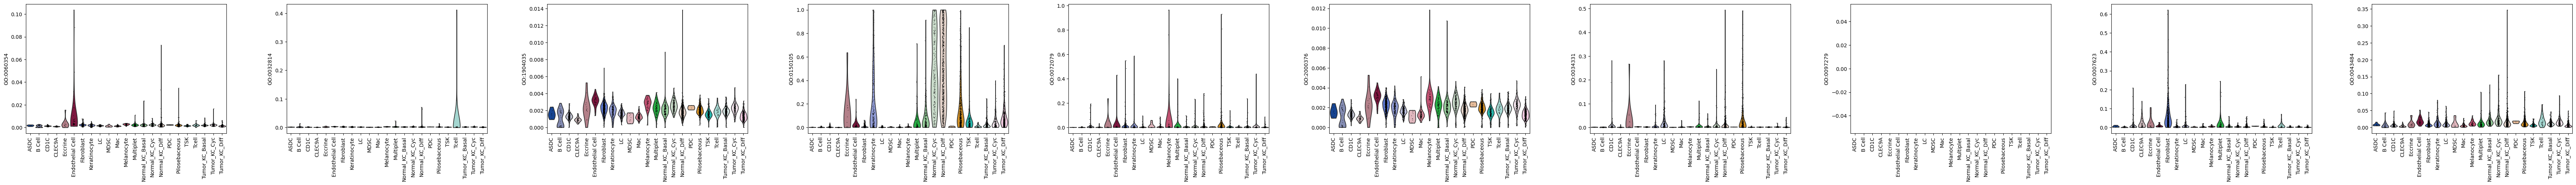

In [524]:
sc.pl.violin(adata, groupby='level2_celltype', keys = rix , rotation=90,)

Some concepts/pathways are mainly expressed in a few cell types, while others have a more unfirom expression across cell types

If we want to, we could also binarize this

In [525]:
concepts_bin = clab.pp.concepts.binarize_concepts(concepts, threshold=0.2)

Override concepts

In [526]:
adata.obs = pd.concat((adata.obs[old_obs_col],concepts_bin),axis = 1)

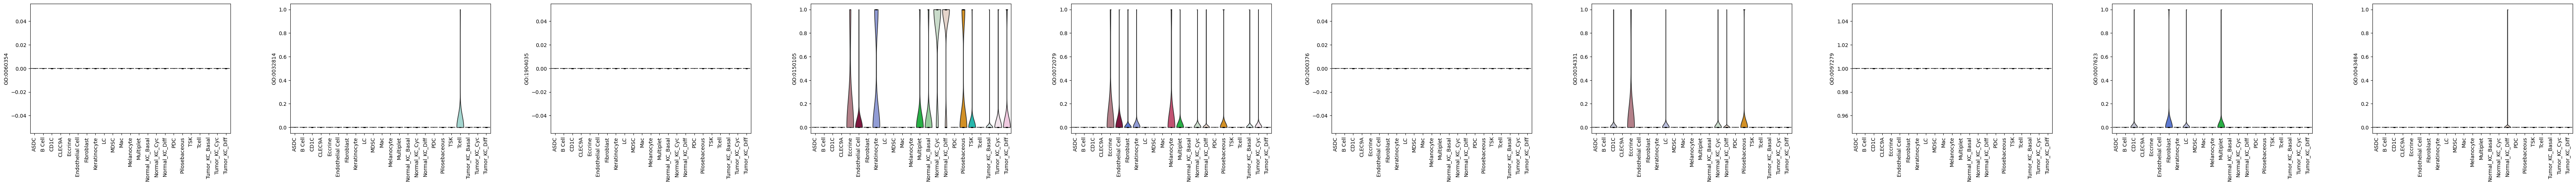

In [510]:
sc.pl.violin(adata, groupby='level2_celltype', keys = rix , rotation=90,)